# Qatar Rental Properties Market Analysis

## Dataset Overview
This analysis examines rental property data scraped from PropertyFinder Qatar on AUG 2025, containing nearly 19,000 properties across 800 pages.

### Dataset Features:
- **title**: Property title/description
- **price**: Monthly rent in QAR  
- **location**: Property location details
- **bedrooms**: Number of bedrooms
- **bathrooms**: Number of bathrooms
- **area**: Property size in sqm
- **property_type**: Type of property (Apartment, Villa, etc.)
- **listing_url**: Link to the original listing

### Analysis Goals:
1. Data cleaning and quality assessment
2. Market overview and trends
3. Price analysis by location and property features
4. Property type distribution
5. Correlation analysis
6. Outlier detection and handling
7. Market insights and recommendations


In [56]:
# Import Libraries and Load Data


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import re


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('qatar_rental_properties.csv')

print("Dataset is loaded!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset is loaded!
Shape: (19118, 8)
Columns: ['title', 'price', 'location', 'bedrooms', 'bathrooms', 'area', 'property_type', 'listing_url']


In [57]:
# Initial Data Exploration


# Display basic information
print("=== DATASET OVERVIEW ===")
print(f"Total properties: {len(df):,}")
print(f"Date: August 2025")
print(f"Unique locations: {df['location'].nunique():,}")

# Display first few rows
print("\n=== FIRST 5 ROWS ===")
display(df.head())

# Display data types and info
print("\n=== DATA TYPES ===")
print(df.dtypes)

=== DATASET OVERVIEW ===
Total properties: 19,118
Date: August 2025
Unique locations: 750

=== FIRST 5 ROWS ===


,title,price,location,bedrooms,bathrooms,area,property_type,listing_url
0,BRAND NEW 2BDR + MAID | FURNISHED | BILLS INCL...,8500,"Dara, Fox Hills, Lusail",8.0,2.0,120,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
1,"2 BHK IN WAKRA,NO COMMISSION,AUGUST FREE",3800,"Al Wakra Hotel, Al Wakra, Al Wakrah, Al Wakra",2.0,2.0,75,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
2,DEAL OF THE MONTH | FURNISHED 2BR | AL WAAB,6200,"Janayin Al Waab, Al Waab, Doha",2.0,2.0,127,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
3,BILLS INCLUDED | NEW 2BR | HOTEL FACILITIES,10154,"West Bay Villas, West Bay, West Bay, Doha",2.0,2.0,137,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
4,BILLS INCLUDED | BRAND NEW | HOTEL FACILITIES,7846,"Burj Doha, West Bay, West Bay, Doha",1.0,1.0,84,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...



=== DATA TYPES ===
title             object
price              int64
location          object
bedrooms         float64
bathrooms        float64
area               int64
property_type     object
listing_url       object
dtype: object


In [58]:
# Convert 'price' to integer, safely
df['price'] = pd.to_numeric(df['price'].replace('[\$,]', '', regex=True), errors='coerce').astype('Int64')

# Convert 'bedrooms' to nullable integer
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce').astype('Int64')

# Convert 'bathrooms' to nullable integer
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce').astype('Int64')

# Clean 'area' and convert to nullable integer
df['area'] = pd.to_numeric(df['area'].replace('[^\d]', '', regex=True), errors='coerce').astype('Int64')


# Display data types and info
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Basic statistics
print("\n=== BASIC STATISTICS ===")
display(df.describe())


=== DATA TYPES ===
title            object
price             Int64
location         object
bedrooms          Int64
bathrooms         Int64
area              Int64
property_type    object
listing_url      object
dtype: object

=== BASIC STATISTICS ===


,price,bedrooms,bathrooms,area
count,19118.0,19103.0,19106.0,19118.0
mean,11787.073491,2.355599,2.916885,236.417878
std,76352.314633,1.713842,2.374139,8713.37126
min,1500.0,1.0,1.0,1.0
25%,6500.0,1.0,1.0,100.0
50%,8500.0,2.0,2.0,125.0
75%,11500.0,3.0,3.0,171.0
max,6000566.0,10.0,10.0,1204500.0


## Data Quality Assessment

Now we'll examine the data quality, missing values, and identify potential issues to create cleaned dataframe.

In [59]:
# Check for missing values
print("=== MISSING VALUES ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Percentage', ascending=False)
print(missing_df)

# Create a copy for cleaning
df_clean = df.copy()

# Drop rows with any missing values
df_clean = df_clean.dropna()

# Remove outliers: Bedrooms and Bathrooms above 8 are very rare and likely invalid
df_clean = df_clean[(df_clean['bedrooms'] <= 8) & (df_clean['bathrooms'] <= 8)]

# Remove outliers in Price using the 98th percentiles
price_q_high = df_clean['price'].quantile(0.99)
df_clean = df_clean[(df_clean['price'] <= price_q_high)]

# Remove outliers in Area using 1st and 99th percentiles
area_q_low = df_clean['area'].quantile(0.01)
area_q_high = df_clean['area'].quantile(0.99)
df_clean = df_clean[(df_clean['area'] >= area_q_low) & (df['area'] <= area_q_high)]

# Final check on data after cleaning
print('')
print(df_clean.describe())
print("Remaining rows after cleaning:", len(df_clean))

=== MISSING VALUES ===
               Missing Count  Percentage
bedrooms                  15    0.078460
bathrooms                 12    0.062768
listing_url                1    0.005231
title                      0    0.000000
location                   0    0.000000
price                      0    0.000000
area                       0    0.000000
property_type              0    0.000000

             price  bedrooms  bathrooms        area
count      16911.0   16911.0    16911.0     16911.0
mean   9635.827331  2.178405   2.394773  160.428952
std     4453.60885  1.279617   1.559172    99.60637
min         1500.0       1.0        1.0        45.0
25%         6500.0       1.0        1.0       100.0
50%         8600.0       2.0        2.0       130.0
75%        11550.0       3.0        3.0       174.0
max        35000.0       8.0        8.0       700.0
Remaining rows after cleaning: 16911


In [60]:
# Extract city from location
def extract_city(location):
    if pd.isna(location) or location == '':
        return 'Unknown'
    parts = location.split(', ')
    return parts[-1] if parts else 'Unknown'

df_clean['city'] = df_clean['location'].apply(extract_city)

# Extract district (second to last part)
def extract_district(location):
    if pd.isna(location) or location == '':
        return 'Unknown'
    parts = location.split(', ')
    return parts[-2] if len(parts) > 1 else 'Unknown'

df_clean['district'] = df_clean['location'].apply(extract_district)

print("=== DATA CLEANING COMPLETED ===")
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")

# Check cleaned data
print("\n=== CLEANED DATA SUMMARY ===")
print(f"Price range: {df_clean['price'].min():,.0f} - {df_clean['price'].max():,.0f} QAR")
print(f"Area range: {df_clean['area'].min():.0f} - {df_clean['area'].max():,.0f} sqm")
print(f"Bedrooms range: {df_clean['bedrooms'].min():.0f} - {df_clean['bedrooms'].max():.0f}")
print(f"Bathrooms range: {df_clean['bathrooms'].min():.0f} - {df_clean['bathrooms'].max():.0f}")

=== DATA CLEANING COMPLETED ===
Original shape: (19118, 8)
Cleaned shape: (16911, 10)

=== CLEANED DATA SUMMARY ===
Price range: 1,500 - 35,000 QAR
Area range: 45 - 700 sqm
Bedrooms range: 1 - 8
Bathrooms range: 1 - 8


In [61]:
# Create visualizations for outliers
import plotly.express as px

# Bedrooms Histogram
fig1 = px.histogram(df_clean, x='bedrooms', nbins=9, title='Bedrooms Distribution')
fig1.update_layout(xaxis_title='Number of Bedrooms', yaxis_title='Count')
fig1.show()

# Bathrooms Histogram
fig2 = px.histogram(df_clean, x='bathrooms', nbins=9, title='Bathrooms Distribution')
fig2.update_layout(xaxis_title='Number of Bathrooms', yaxis_title='Count')
fig2.show()

# Price Histogram
fig3 = px.histogram(df_clean, x='price', nbins=100, title='Price Distribution (QAR)')
fig3.update_layout(xaxis_title='Price (QAR)', yaxis_title='Count')
fig3.show()

# Area Histogram
fig4 = px.histogram(df_clean, x='area', nbins=100, title='Area Distribution (sqm)')
fig4.update_layout(xaxis_title='Area (sqm)', yaxis_title='Count')
fig4.show()


In [62]:
df_clean.head()

,title,price,location,bedrooms,bathrooms,area,property_type,listing_url,city,district
0,BRAND NEW 2BDR + MAID | FURNISHED | BILLS INCL...,8500,"Dara, Fox Hills, Lusail",8,2,120,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Lusail,Fox Hills
1,"2 BHK IN WAKRA,NO COMMISSION,AUGUST FREE",3800,"Al Wakra Hotel, Al Wakra, Al Wakrah, Al Wakra",2,2,75,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Al Wakra,Al Wakrah
2,DEAL OF THE MONTH | FURNISHED 2BR | AL WAAB,6200,"Janayin Al Waab, Al Waab, Doha",2,2,127,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,Al Waab
3,BILLS INCLUDED | NEW 2BR | HOTEL FACILITIES,10154,"West Bay Villas, West Bay, West Bay, Doha",2,2,137,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay
4,BILLS INCLUDED | BRAND NEW | HOTEL FACILITIES,7846,"Burj Doha, West Bay, West Bay, Doha",1,1,84,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay


In [63]:
# Adding a new column street_name extracted from location
# Droping the location column
# Correct bedrooms, bathrooms, and property_type by extracting from title



# --- 1. Extract street name (first part before comma)
df_clean["street"] = df_clean["location"].apply(lambda x: x.split(",")[0].strip() if pd.notna(x) else None)

# --- 2. Drop location column
df_clean.drop(columns=["location"], inplace=True)

# --- 3. Fix bedrooms, bathrooms, property_type based on title
def extract_from_title(title):
    result = {"bedrooms": None, "bathrooms": None, "property_type": None}
    
    # Bedrooms
    match_bed = re.search(r"(\d+)\s*(BR|BDR|BHK|bed|Bedroom|غرف)", title, re.IGNORECASE)
    if match_bed:
        result["bedrooms"] = int(match_bed.group(1))

    # Bathrooms (try 2 bath, 2 bathrooms)
    match_bath = re.search(r"(\d+)\s*(bath|Bathroom|حمام)", title, re.IGNORECASE)
    if match_bath:
        result["bathrooms"] = int(match_bath.group(1))

    # Property type
    if re.search(r"villa|فيلا", title, re.IGNORECASE):
        result["property_type"] = "Villa"
    elif re.search(r"apartment|شقة", title, re.IGNORECASE):
        result["property_type"] = "Apartment"
    elif re.search(r"penthouse", title, re.IGNORECASE):
        result["property_type"] = "Penthouse"
    elif re.search(r"studio", title, re.IGNORECASE):
        result["property_type"] = "Studio"

    return pd.Series(result)

# Apply corrections
corrections = df_clean["title"].apply(extract_from_title)

# Overwrite if value is extracted from title
df_clean["bedrooms"] = corrections["bedrooms"].combine_first(df_clean["bedrooms"])
df_clean["bathrooms"] = corrections["bathrooms"].combine_first(df_clean["bathrooms"])
df_clean["property_type"] = corrections["property_type"].combine_first(df_clean["property_type"])

df_clean.head(10)

,title,price,bedrooms,bathrooms,area,property_type,listing_url,city,district,street
0,BRAND NEW 2BDR + MAID | FURNISHED | BILLS INCL...,8500,2.0,2.0,120,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Lusail,Fox Hills,Dara
1,"2 BHK IN WAKRA,NO COMMISSION,AUGUST FREE",3800,2.0,2.0,75,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Al Wakra,Al Wakrah,Al Wakra Hotel
2,DEAL OF THE MONTH | FURNISHED 2BR | AL WAAB,6200,2.0,2.0,127,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,Al Waab,Janayin Al Waab
3,BILLS INCLUDED | NEW 2BR | HOTEL FACILITIES,10154,2.0,2.0,137,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay,West Bay Villas
4,BILLS INCLUDED | BRAND NEW | HOTEL FACILITIES,7846,1.0,1.0,84,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay,Burj Doha
5,COZY 1BR APARTMENT | BILLS INCLUDED | BEACH VIEW,7543,1.0,2.0,96,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,The Pearl Island,Tower 2
6,MOVE-IN READY | 2 BEDROOMS | BILLS INCLUDED,11500,2.0,2.0,160,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay,West Bay Tower
7,EXECUTIVE | BRAND NEW | 1 BEDROOM,8500,1.0,1.0,89,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay,West Bay Tower
8,Brand New 2 BHK | Wifi Included | No Commission,6000,2.0,2.0,110,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,Al Duhail,CAP30DHL
9,BILLS INCLUDED | NEW 3BR+M | HOTEL FACILITIES,14000,3.0,3.0,220,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...,Doha,West Bay,West Bay Villas


In [64]:
# Remove outliers: Bedrooms and Bathrooms above 8 are very rare and likely invalid
df_clean = df_clean[(df_clean['bedrooms'] <= 8) & (df_clean['bathrooms'] <= 8)]

# Convert 'bedrooms' to integer
df_clean['bedrooms'] = pd.to_numeric(df_clean['bedrooms'], errors='coerce').astype('Int64')

# Convert 'bathrooms' to integer
df_clean['bathrooms'] = pd.to_numeric(df_clean['bathrooms'], errors='coerce').astype('Int64')

print(df_clean.info())
print(df_clean.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 16910 entries, 0 to 19116
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          16910 non-null  object
 1   price          16910 non-null  Int64 
 2   bedrooms       16910 non-null  Int64 
 3   bathrooms      16910 non-null  Int64 
 4   area           16910 non-null  Int64 
 5   property_type  16910 non-null  object
 6   listing_url    16910 non-null  object
 7   city           16910 non-null  object
 8   district       16910 non-null  object
 9   street         16910 non-null  object
dtypes: Int64(4), object(6)
memory usage: 1.5+ MB
None
             price  bedrooms  bathrooms        area
count      16910.0   16910.0    16910.0     16910.0
mean   9635.628386  2.159432   2.393732  160.414784
std    4453.665394  1.245636   1.556029   99.592274
min         1500.0       1.0        1.0        45.0
25%         6500.0       1.0        1.0       100.0
50%         8

In [65]:
# Checking the property types and counts

print(df_clean['property_type'].unique())

print(f"Apartments: {len(df_clean[df_clean.property_type == 'Apartment'])}")
print(f"Studios: {len(df_clean[df_clean.property_type == 'Studio'])}")
print(f"Villas: {len(df_clean[df_clean.property_type == 'Villa'])}")
print(f"Penthouses: {len(df_clean[df_clean.property_type == 'Penthouse'])}")
print(f"Townhouses: {len(df_clean[df_clean.property_type == 'Townhouse'])}")

['Apartment' 'Studio' 'Villa' 'Penthouse' 'Townhouse']
Apartments: 14056
Studios: 652
Villas: 1846
Penthouses: 194
Townhouses: 162


## Market Overview and Distribution Analysis

Let's explore the overall market characteristics and distributions.

In [66]:
# Market summary statistics
print("=== QATAR RENTAL MARKET OVERVIEW ===")
print(f"Total Properties Analyzed: {len(df_clean):,}")
print(f"Average Monthly Rent: {df_clean['price'].mean():,.0f} QAR")
print(f"Median Monthly Rent: {df_clean['price'].median():,.0f} QAR")
print(f"Average Property Size: {df_clean['area'].mean():.0f} sqm")
print(f"Most Common Property Type: {df_clean['property_type'].mode()[0]}")
print(f"Most Popular Location: {df_clean['city'].mode()[0]}")

# Create comprehensive overview dashboard
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=['Price Distribution', 'Property Types', 'Bedrooms Distribution',
                   'Area Distribution', 'Top 10 Cities', 'Price by Property Type'],
    specs=[[{"secondary_y": False}, {"type": "pie"}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

# Price distribution
fig.add_trace(
    go.Histogram(x=df_clean['price'], nbinsx=100, name='Price'),
    row=1, col=1
)

# Property types pie chart
property_counts = df_clean['property_type'].value_counts()
fig.add_trace(
    go.Pie(labels=property_counts.index, values=property_counts.values, name="Property Types"),
    row=1, col=2
)

# Bedrooms distribution
fig.add_trace(
    go.Histogram(x=df_clean['bedrooms'], nbinsx=10, name='Bedrooms', texttemplate='%{y}', textposition='outside'),
    row=1, col=3
)

# Area distribution
fig.add_trace(
    go.Histogram(x=df_clean['area'], nbinsx=100, name='Area'),
    row=2, col=1
)

# Top 10 cities
top_cities = df_clean['city'].value_counts().head(10)
fig.add_trace(
    go.Bar(x=top_cities.values, y=top_cities.index, orientation='h', name='Cities', text=top_cities.values), 
    row=2, col=2
)

# Price by property type
price_by_type = df_clean.groupby('property_type')['price'].mean().sort_values(ascending=True)
fig.add_trace(
    go.Bar(x=price_by_type.values, y=price_by_type.index, orientation='h', name='Avg Price'),
    row=2, col=3
)

fig.update_layout(height=800, showlegend=False, title_text="Qatar Rental Market Overview")
fig.show()

=== QATAR RENTAL MARKET OVERVIEW ===
Total Properties Analyzed: 16,910
Average Monthly Rent: 9,636 QAR
Median Monthly Rent: 8,600 QAR
Average Property Size: 160 sqm
Most Common Property Type: Apartment
Most Popular Location: Doha


## Price Analysis

Deep dive into rental price patterns across different dimensions.

=== PRICE ANALYSIS BY PROPERTY TYPE ===


,Count,Mean,Median,Std Dev,Min,Max
property_type,,,,,,
Apartment,14056,9083.0,8500.0,3698.0,1800,35000
Penthouse,194,19327.0,19371.0,8156.0,2200,35000
Studio,652,5572.0,6000.0,1514.0,1500,11000
Townhouse,162,15442.0,13000.0,6001.0,7000,35000
Villa,1846,13749.0,12000.0,5362.0,1800,35000



=== PRICE PER SQM ANALYSIS ===


,Mean QAR/sqm,Median QAR/sqm,Std Dev
property_type,,,
Apartment,68.73,66.67,20.49
Penthouse,76.7,74.75,23.13
Studio,86.71,88.71,25.62
Townhouse,79.26,76.48,23.93
Villa,41.84,38.0,17.61



=== TOP 10 MOST EXPENSIVE DISTRICTS ===


,district,count,mean
103,West Bay Lagoon,277,20583.0
67,Les Maisons Blanches,10,19800.0
7,Al Dafna,22,14905.0
27,Al Messila,30,14618.0
26,Al Markhiya,30,13982.0
95,Umm Al Amad,23,13535.0
12,Al Hilal,97,13416.0
92,Sumaysimah,31,12790.0
38,Al Soudan,42,12488.0
44,AlMuraikh,120,12353.0


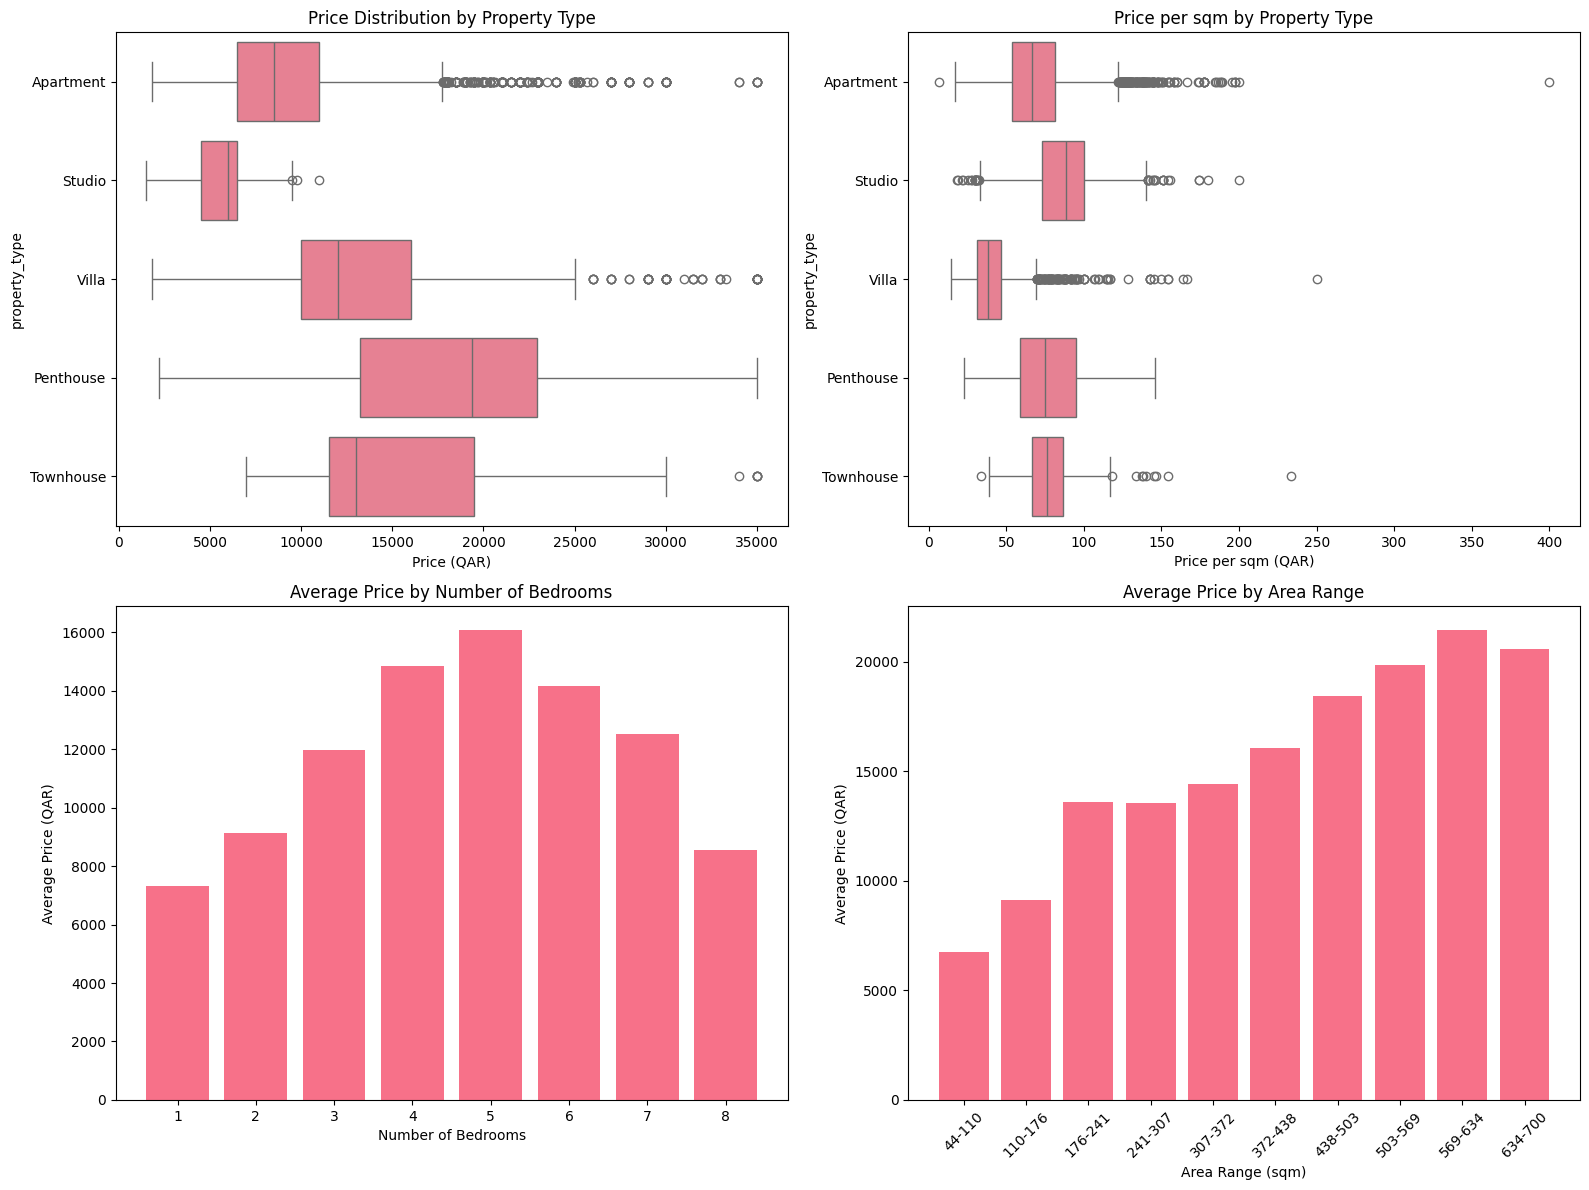

In [67]:
# Price statistics by property type
print("=== PRICE ANALYSIS BY PROPERTY TYPE ===")
price_stats = df_clean.groupby('property_type')['price'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(0)
price_stats.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
display(price_stats)

# Price per sqm analysis
df_clean['price_per_sqm'] = df_clean['price'] / df_clean['area']

print("\n=== PRICE PER SQM ANALYSIS ===")
price_per_sqm_stats = df_clean.groupby('property_type')['price_per_sqm'].agg([
    'mean', 'median', 'std'
]).round(2)
price_per_sqm_stats.columns = ['Mean QAR/sqm', 'Median QAR/sqm', 'Std Dev']
display(price_per_sqm_stats)

# Top 10 most expensive locations
print("\n=== TOP 10 MOST EXPENSIVE DISTRICTS ===")
expensive_districts = df_clean.groupby('district')['price'].agg(['count', 'mean']).reset_index()
expensive_districts = expensive_districts[expensive_districts['count'] >= 10]  # At least 10 properties
expensive_districts = expensive_districts.sort_values('mean', ascending=False).head(10)
expensive_districts['mean'] = expensive_districts['mean'].round(0)
display(expensive_districts)

# Create price analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price by property type boxplot
sns.boxplot(data=df_clean, y='property_type', x='price', ax=axes[0,0])
axes[0,0].set_title('Price Distribution by Property Type')
axes[0,0].set_xlabel('Price (QAR)')

# Price per sqm by property type
sns.boxplot(data=df_clean, y='property_type', x='price_per_sqm', ax=axes[0,1])
axes[0,1].set_title('Price per sqm by Property Type')
axes[0,1].set_xlabel('Price per sqm (QAR)')

# Price by number of bedrooms
bedroom_price = df_clean.groupby('bedrooms')['price'].mean()
axes[1,0].bar(bedroom_price.index, bedroom_price.values)
axes[1,0].set_title('Average Price by Number of Bedrooms')
axes[1,0].set_xlabel('Number of Bedrooms')
axes[1,0].set_ylabel('Average Price (QAR)')

# Price trend by area
area_bins = pd.cut(df_clean['area'], bins=10)
price_by_area = df_clean.groupby(area_bins)['price'].mean()
area_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in price_by_area.index]
axes[1,1].bar(range(len(price_by_area)), price_by_area.values)
axes[1,1].set_title('Average Price by Area Range')
axes[1,1].set_xlabel('Area Range (sqm)')
axes[1,1].set_ylabel('Average Price (QAR)')
axes[1,1].set_xticks(range(len(area_labels)))
axes[1,1].set_xticklabels(area_labels, rotation=45)

plt.tight_layout()
plt.show()

## Location Analysis

Exploring rental patterns across different areas in Qatar.

=== LOCATION ANALYSIS ===
Top cities by average rent (minimum 20 properties):


,Property_Count,Avg_Price,Median_Price,Avg_Area,Avg_Price_per_sqm
city,,,,,
Al Shamal,23,13534.78,7500.0,316.17,43.02
Doha,13704,9790.41,8993.0,165.43,66.14
Al Khor,96,9312.48,9000.0,289.49,35.86
Lusail,2851,9096.63,8500.0,128.17,72.52
Umm Salal Mohammed,95,8381.15,7500.0,193.01,48.86
Al Wakra,132,5701.14,4475.0,183.56,38.42



=== TOP DOHA DISTRICTS ===


,Count,Avg_Price,Avg_Price_per_sqm
district,,,
West Bay Lagoon,277,20582.99,57.24
Al Dafna,22,14904.55,64.65
Al Messila,30,14618.43,54.81
Al Markhiya,30,13981.67,43.62
Al Hilal,97,13416.04,41.53
Diplomatic Area,7,13304.14,74.23
Al Soudan,42,12488.1,41.77
AlMuraikh,120,12353.25,45.58
Hazm Al Markhiya,12,12095.83,54.27


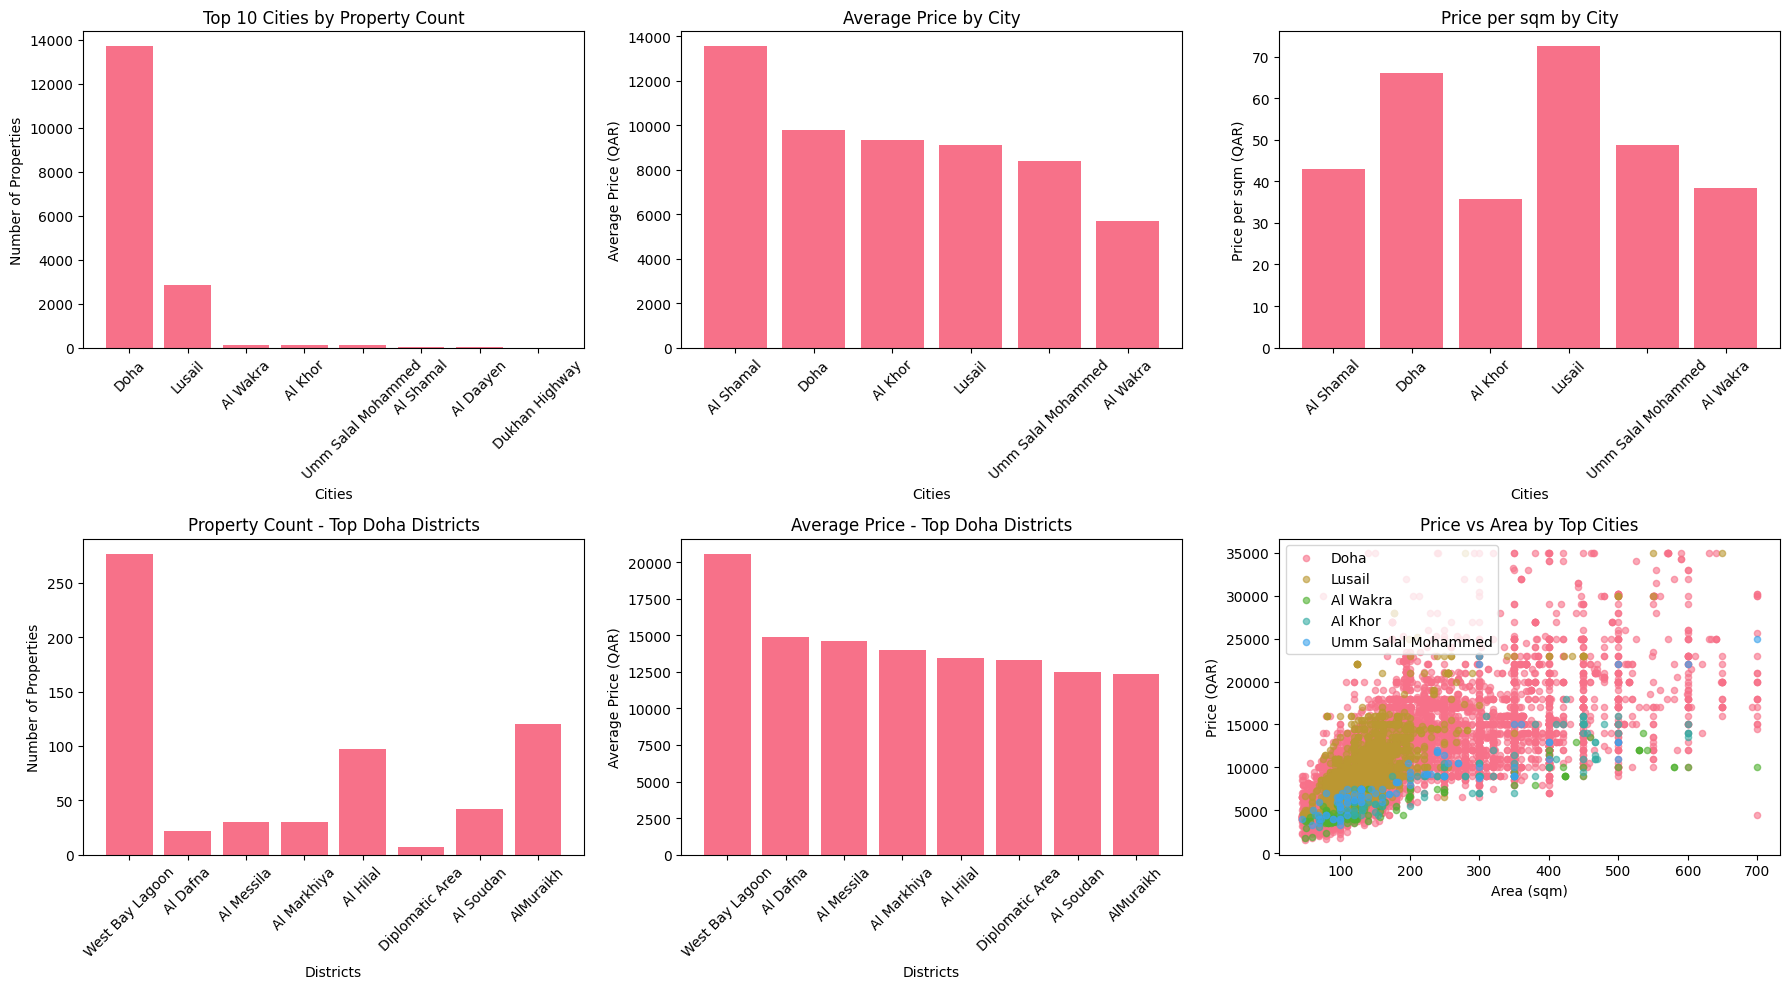

In [68]:
# City analysis
print("=== LOCATION ANALYSIS ===")
city_stats = df_clean.groupby('city').agg({
    'price': ['count', 'mean', 'median'],
    'area': 'mean',
    'price_per_sqm': 'mean'
}).round(2)

city_stats.columns = ['Property_Count', 'Avg_Price', 'Median_Price', 'Avg_Area', 'Avg_Price_per_sqm']
city_stats = city_stats[city_stats['Property_Count'] >= 20].sort_values('Avg_Price', ascending=False)

print("Top cities by average rent (minimum 20 properties):")
display(city_stats.head(10))

# District analysis within Doha
doha_districts = df_clean[df_clean['city'] == 'Doha'].groupby('district').agg({
    'price': ['count', 'mean'],
    'price_per_sqm': 'mean'
}).round(2)

doha_districts.columns = ['Count', 'Avg_Price', 'Avg_Price_per_sqm']
doha_districts = doha_districts[doha_districts['Count'] >= 5].sort_values('Avg_Price', ascending=False)

print("\n=== TOP DOHA DISTRICTS ===")
display(doha_districts.head(10))

# Create location visualizations
plt.figure(figsize=(18, 10))

# Top cities by property count
plt.subplot(2, 3, 1)
top_cities_count = df_clean['city'].value_counts().head(10)
plt.bar(range(len(top_cities_count)), top_cities_count.values)
plt.title('Top 10 Cities by Property Count')
plt.xlabel('Cities')
plt.ylabel('Number of Properties')
plt.xticks(range(len(top_cities_count)), top_cities_count.index, rotation=45)

# Average price by top cities
plt.subplot(2, 3, 2)
top_cities_price = city_stats.head(8)
plt.bar(range(len(top_cities_price)), top_cities_price['Avg_Price'])
plt.title('Average Price by City')
plt.xlabel('Cities')
plt.ylabel('Average Price (QAR)')
plt.xticks(range(len(top_cities_price)), top_cities_price.index, rotation=45)

# Price per sqm by city
plt.subplot(2, 3, 3)
plt.bar(range(len(top_cities_price)), top_cities_price['Avg_Price_per_sqm'])
plt.title('Price per sqm by City')
plt.xlabel('Cities')
plt.ylabel('Price per sqm (QAR)')
plt.xticks(range(len(top_cities_price)), top_cities_price.index, rotation=45)

# Doha districts - property count
plt.subplot(2, 3, 4)
top_doha_districts = doha_districts.head(8)
plt.bar(range(len(top_doha_districts)), top_doha_districts['Count'])
plt.title('Property Count - Top Doha Districts')
plt.xlabel('Districts')
plt.ylabel('Number of Properties')
plt.xticks(range(len(top_doha_districts)), top_doha_districts.index, rotation=45)

# Doha districts - average price
plt.subplot(2, 3, 5)
plt.bar(range(len(top_doha_districts)), top_doha_districts['Avg_Price'])
plt.title('Average Price - Top Doha Districts')
plt.xlabel('Districts')
plt.ylabel('Average Price (QAR)')
plt.xticks(range(len(top_doha_districts)), top_doha_districts.index, rotation=45)

# Price vs Area scatter by city
plt.subplot(2, 3, 6)
for city in df_clean['city'].value_counts().head(5).index:
    city_data = df_clean[df_clean['city'] == city]
    plt.scatter(city_data['area'], city_data['price'], 
               alpha=0.6, label=city, s=20)
plt.xlabel('Area (sqm)')
plt.ylabel('Price (QAR)')
plt.title('Price vs Area by Top Cities')
plt.legend()

plt.tight_layout()
plt.show()

## Property Features Analysis

Analyzing the relationship between property features (bedrooms, bathrooms, area) and rental prices.


=== BEDROOM ANALYSIS ===


,Count,Avg_Price,Median_Price,Avg_Area,Price_per_sqm
bedrooms,,,,,
1,5681,7317.33,7500.0,97.07,77.73
2,6451,9119.98,9000.0,136.51,66.77
3,2870,11971.9,12000.0,207.72,59.6
4,898,14858.63,13000.0,344.77,44.25
5,586,16088.17,15000.0,400.67,42.05
6,243,14154.67,12000.0,389.39,42.32
7,105,12534.8,12000.0,308.14,49.41
8,76,8551.54,6715.0,171.34,58.73



=== BATHROOM ANALYSIS ===


,Count,Avg_Price,Median_Price,Avg_Area
bathrooms,,,,
1,5144,7490.13,7500.0,98.28
2,6267,9147.25,9000.0,136.32
3,2865,11936.49,12000.0,206.13
4,962,14390.53,12923.0,327.64
5,677,15007.05,14000.0,365.09
6,330,11664.14,11000.0,311.26
7,328,8687.18,6430.5,187.54
8,337,6478.88,6000.0,105.63



=== AREA RANGE ANALYSIS ===


,Count,Avg_Price,Median_Price,Price_per_sqm
area_range,,,,
<50,206,4544.66,4350.0,94.25
50-100,4383,6711.85,6500.0,79.26
100-150,6581,8200.09,8000.0,65.42
150-200,2662,11903.96,11769.0,69.05
200-300,1458,13938.43,13500.0,55.7
300-500,1428,15849.41,15000.0,40.97
500+,192,20707.64,20000.0,35.09


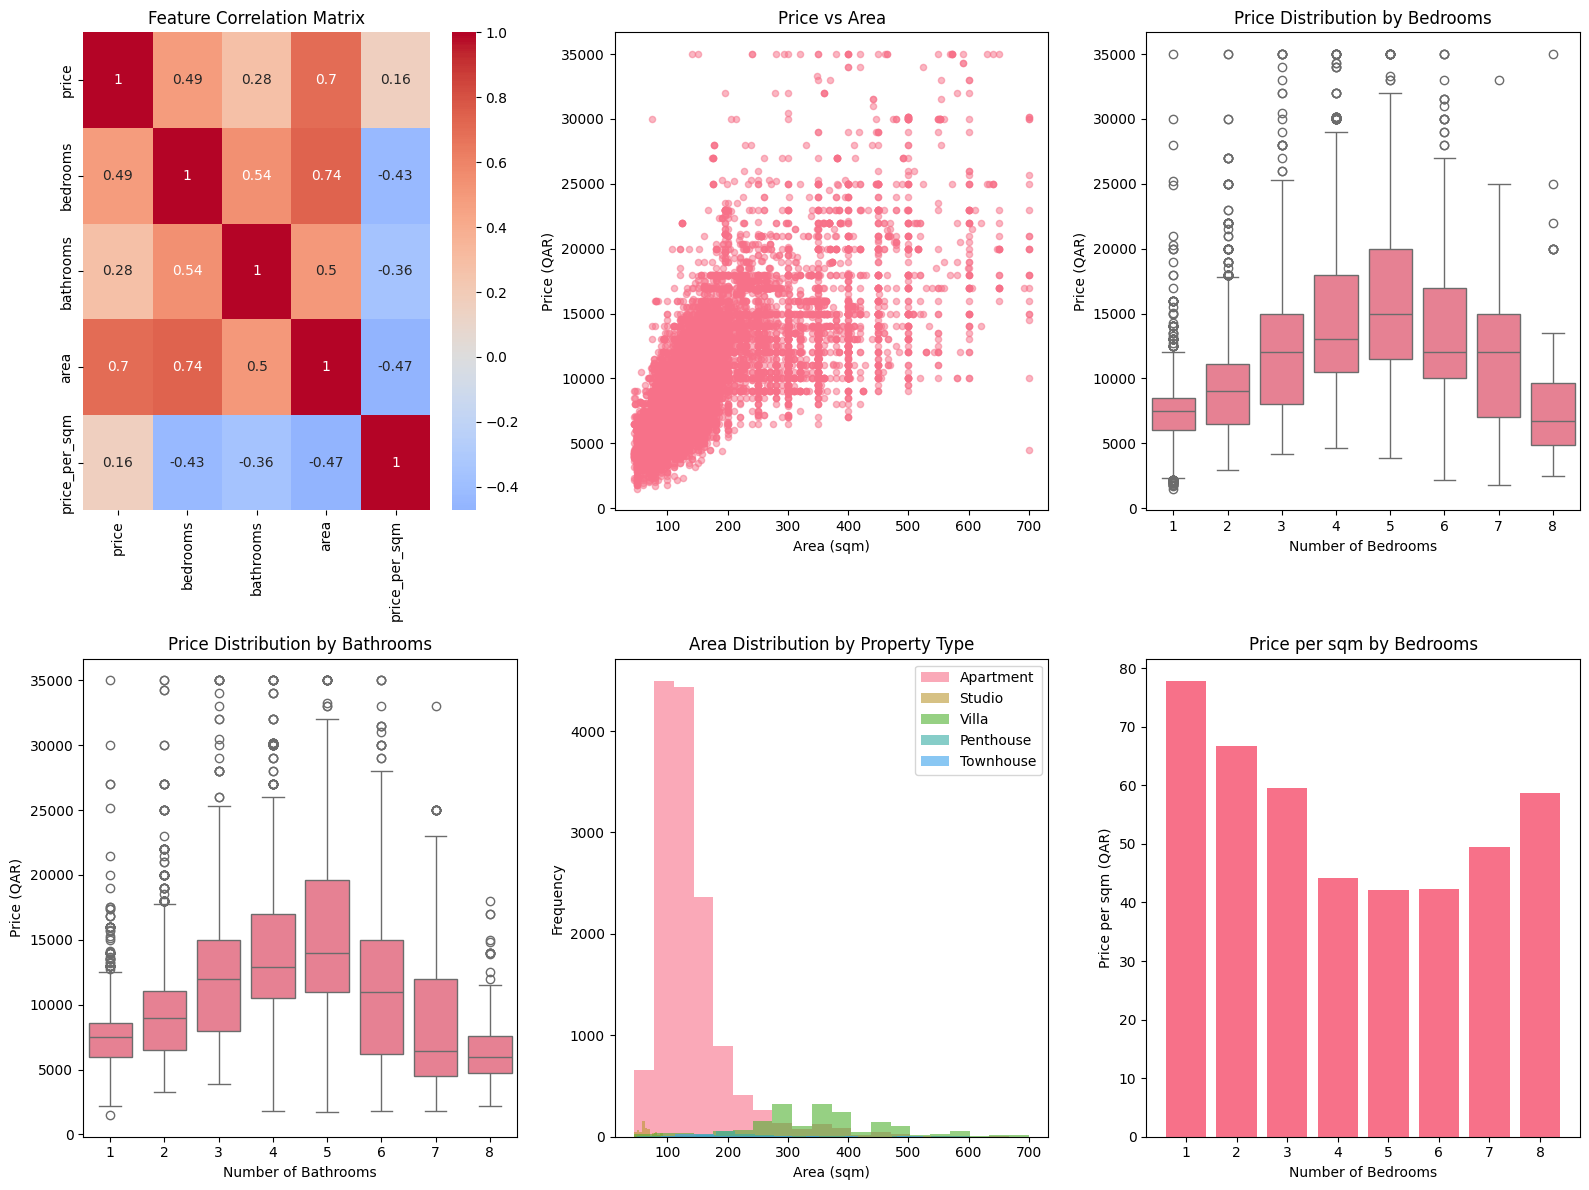

In [69]:
# Bedroom analysis
print("=== BEDROOM ANALYSIS ===")
bedroom_analysis = df_clean.groupby('bedrooms').agg({
    'price': ['count', 'mean', 'median'],
    'area': 'mean',
    'price_per_sqm': 'mean'
}).round(2)

bedroom_analysis.columns = ['Count', 'Avg_Price', 'Median_Price', 'Avg_Area', 'Price_per_sqm']
display(bedroom_analysis)

# Bathroom analysis
print("\n=== BATHROOM ANALYSIS ===")
bathroom_analysis = df_clean.groupby('bathrooms').agg({
    'price': ['count', 'mean', 'median'],
    'area': 'mean'
}).round(2)

bathroom_analysis.columns = ['Count', 'Avg_Price', 'Median_Price', 'Avg_Area']
display(bathroom_analysis)

# Area ranges analysis
print("\n=== AREA RANGE ANALYSIS ===")
df_clean['area_range'] = pd.cut(df_clean['area'], 
                                  bins=[0, 50, 100, 150, 200, 300, 500, 2000],
                                  labels=['<50', '50-100', '100-150', '150-200', '200-300', '300-500', '500+'])

area_analysis = df_clean.groupby('area_range').agg({
    'price': ['count', 'mean', 'median'],
    'price_per_sqm': 'mean'
}).round(2)

area_analysis.columns = ['Count', 'Avg_Price', 'Median_Price', 'Price_per_sqm']
display(area_analysis)

# Create correlation matrix
numeric_columns = ['price', 'bedrooms', 'bathrooms', 'area', 'price_per_sqm']
correlation_matrix = df_clean[numeric_columns].corr()

plt.figure(figsize=(16, 12))

# Correlation heatmap
plt.subplot(2, 3, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

# Price vs Area scatter
plt.subplot(2, 3, 2)
plt.scatter(df_clean['area'], df_clean['price'], alpha=0.5, s=20)
plt.xlabel('Area (sqm)')
plt.ylabel('Price (QAR)')
plt.title('Price vs Area')

# Price vs Bedrooms
plt.subplot(2, 3, 3)
sns.boxplot(data=df_clean, x='bedrooms', y='price')
plt.title('Price Distribution by Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (QAR)')

# Price vs Bathrooms
plt.subplot(2, 3, 4)
sns.boxplot(data=df_clean, x='bathrooms', y='price')
plt.title('Price Distribution by Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price (QAR)')

# Area distribution by property type
plt.subplot(2, 3, 5)
for prop_type in df_clean['property_type'].unique():
    type_data = df_clean[df_clean['property_type'] == prop_type]
    plt.hist(type_data['area'], alpha=0.6, label=prop_type, bins=20)
plt.xlabel('Area (sqm)')
plt.ylabel('Frequency')
plt.title('Area Distribution by Property Type')
plt.legend()

# Price per sqm by bedrooms
plt.subplot(2, 3, 6)
bedroom_price_per_sqm = df_clean.groupby('bedrooms')['price_per_sqm'].mean()
plt.bar(bedroom_price_per_sqm.index, bedroom_price_per_sqm.values)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price per sqm (QAR)')
plt.title('Price per sqm by Bedrooms')

plt.tight_layout()
plt.show()

## Market Insights and Patterns

Identifying key patterns and insights in the Qatar rental market.


In [70]:
print("=== QATAR RENTAL MARKET INSIGHTS ===\n")

# 1. Market composition
print("1. MARKET COMPOSITION:")
total_properties = len(df_clean)
for prop_type in df_clean['property_type'].value_counts().index:
    count = df_clean['property_type'].value_counts()[prop_type]
    percentage = (count / total_properties) * 100
    avg_price = df_clean[df_clean['property_type'] == prop_type]['price'].mean()
    print(f"   {prop_type}: {count:,} properties ({percentage:.1f}%) - Avg: {avg_price:,.0f} QAR")

# 2. Price insights
print("\n2. PRICE INSIGHTS:")
print(f"   Overall average rent: {df_clean['price'].mean():,.0f} QAR/month")
print(f"   Overall median rent: {df_clean['price'].median():,.0f} QAR/month")
print(f"   Most affordable 25%: Below {df_clean['price'].quantile(0.25):,.0f} QAR")
print(f"   Most expensive 25%: Above {df_clean['price'].quantile(0.75):,.0f} QAR")
print(f"   Average price per sqm: {df_clean['price_per_sqm'].mean():.2f} QAR/sqm")

# 3. Location insights
print("\n3. LOCATION INSIGHTS:")
doha_percentage = (df_clean['city'].value_counts()['Doha'] / total_properties) * 100
print(f"   Doha dominates: {df_clean['city'].value_counts()['Doha']:,} properties ({doha_percentage:.1f}%)")
print(f"   Most expensive city: {city_stats.index[0]} (Avg: {city_stats.iloc[0]['Avg_Price']:,.0f} QAR)")
print(f"   Highest price per sqm: {city_stats.sort_values('Avg_Price_per_sqm', ascending=False).index[0]}")

# 4. Property size insights
print("\n4. PROPERTY SIZE INSIGHTS:")
print(f"   Average area: {df_clean['area'].mean():.0f} sqm")
print(f"   Most common bedroom count: {df_clean['bedrooms'].mode()[0]:.0f} bedrooms")
print(f"   Most common bathroom count: {df_clean['bathrooms'].mode()[0]:.0f} bathrooms")

# 5. Value insights
print("\n5. VALUE INSIGHTS:")
best_value_city = city_stats.sort_values('Avg_Price_per_sqm').index[0]
best_value_price = city_stats.sort_values('Avg_Price_per_sqm').iloc[0]['Avg_Price_per_sqm']
print(f"   Best value city: {best_value_city} ({best_value_price:.2f} QAR/sqm)")

# Most affordable vs most expensive property types
affordable_type = price_stats.sort_values('Mean').index[0]
expensive_type = price_stats.sort_values('Mean').index[-1]
affordable_price = price_stats.sort_values('Mean').iloc[0]['Mean']
expensive_price = price_stats.sort_values('Mean').iloc[-1]['Mean']
print(f"   Most affordable type: {affordable_type} (Avg: {affordable_price:,.0f} QAR)")
print(f"   Most expensive type: {expensive_type} (Avg: {expensive_price:,.0f} QAR)")

# 6. Market opportunities
print("\n6. MARKET OPPORTUNITIES:")
# Areas with high supply
high_supply = df_clean['district'].value_counts().head(3)
print("   High supply areas:")
for district, count in high_supply.items():
    avg_price = df_clean[df_clean['district'] == district]['price'].mean()
    print(f"     {district}: {count} properties (Avg: {avg_price:,.0f} QAR)")

# Premium locations (high price per sqm)
premium_locations = doha_districts.sort_values('Avg_Price_per_sqm', ascending=False).head(3)
print("\n   Premium locations (Doha districts):")
for district in premium_locations.index:
    price_per_sqm = premium_locations.loc[district, 'Avg_Price_per_sqm']
    avg_price = premium_locations.loc[district, 'Avg_Price']
    print(f"     {district}: {price_per_sqm:.2f} QAR/sqm (Avg: {avg_price:,.0f} QAR)")

=== QATAR RENTAL MARKET INSIGHTS ===

1. MARKET COMPOSITION:
   Apartment: 14,056 properties (83.1%) - Avg: 9,083 QAR
   Villa: 1,846 properties (10.9%) - Avg: 13,749 QAR
   Studio: 652 properties (3.9%) - Avg: 5,572 QAR
   Penthouse: 194 properties (1.1%) - Avg: 19,327 QAR
   Townhouse: 162 properties (1.0%) - Avg: 15,442 QAR

2. PRICE INSIGHTS:
   Overall average rent: 9,636 QAR/month
   Overall median rent: 8,600 QAR/month
   Most affordable 25%: Below 6,500 QAR
   Most expensive 25%: Above 11,550 QAR
   Average price per sqm: 66.68 QAR/sqm

3. LOCATION INSIGHTS:
   Doha dominates: 13,704 properties (81.0%)
   Most expensive city: Al Shamal (Avg: 13,535 QAR)
   Highest price per sqm: Lusail

4. PROPERTY SIZE INSIGHTS:
   Average area: 160 sqm
   Most common bedroom count: 2 bedrooms
   Most common bathroom count: 2 bathrooms

5. VALUE INSIGHTS:
   Best value city: Al Khor (35.86 QAR/sqm)
   Most affordable type: Studio (Avg: 5,572 QAR)
   Most expensive type: Penthouse (Avg: 19,327 

## Advanced Analytics

Performing advanced analysis including price prediction factors and market segmentation.


=== MARKET SEGMENTATION ===
Market segments:


,Count,Avg_Price,Min_Price,Max_Price,Avg_Area,Avg_Bedrooms,Price_per_sqm
price_segment,,,,,,,
Budget,4604,5377.82,1500,6500,100.14,1.74,57.71
Mid-Range,3853,7729.39,6503,8600,117.23,1.59,70.58
Premium,4231,10001.54,8615,11550,164.6,2.17,70.46
Luxury,4222,15651.62,11571,35000,261.36,3.13,69.13



=== PROPERTY TYPE BY PRICE SEGMENT ===


property_type,Apartment,Penthouse,Studio,Townhouse,Villa
price_segment,,,,,
Budget,86.6,0.2,11.9,0.0,1.3
Mid-Range,95.0,0.3,2.4,0.2,2.2
Premium,83.5,0.2,0.3,0.9,15.1
Luxury,68.1,3.9,0.0,2.8,25.2



=== TOP LOCATIONS BY PRICE SEGMENT ===

Budget Segment:
  Al Sadd: 479 properties (Avg: 5,494 QAR)
  The Pearl Island: 468 properties (Avg: 6,063 QAR)
  Fox Hills: 408 properties (Avg: 5,655 QAR)

Mid-Range Segment:
  The Pearl Island: 1503 properties (Avg: 7,789 QAR)
  Marina District: 469 properties (Avg: 7,969 QAR)
  West Bay: 343 properties (Avg: 7,818 QAR)

Premium Segment:
  The Pearl Island: 1826 properties (Avg: 9,978 QAR)
  Marina District: 498 properties (Avg: 10,042 QAR)
  West Bay: 489 properties (Avg: 10,151 QAR)

Luxury Segment:
  The Pearl Island: 1877 properties (Avg: 15,531 QAR)
  Marina District: 375 properties (Avg: 14,159 QAR)
  West Bay: 349 properties (Avg: 15,560 QAR)


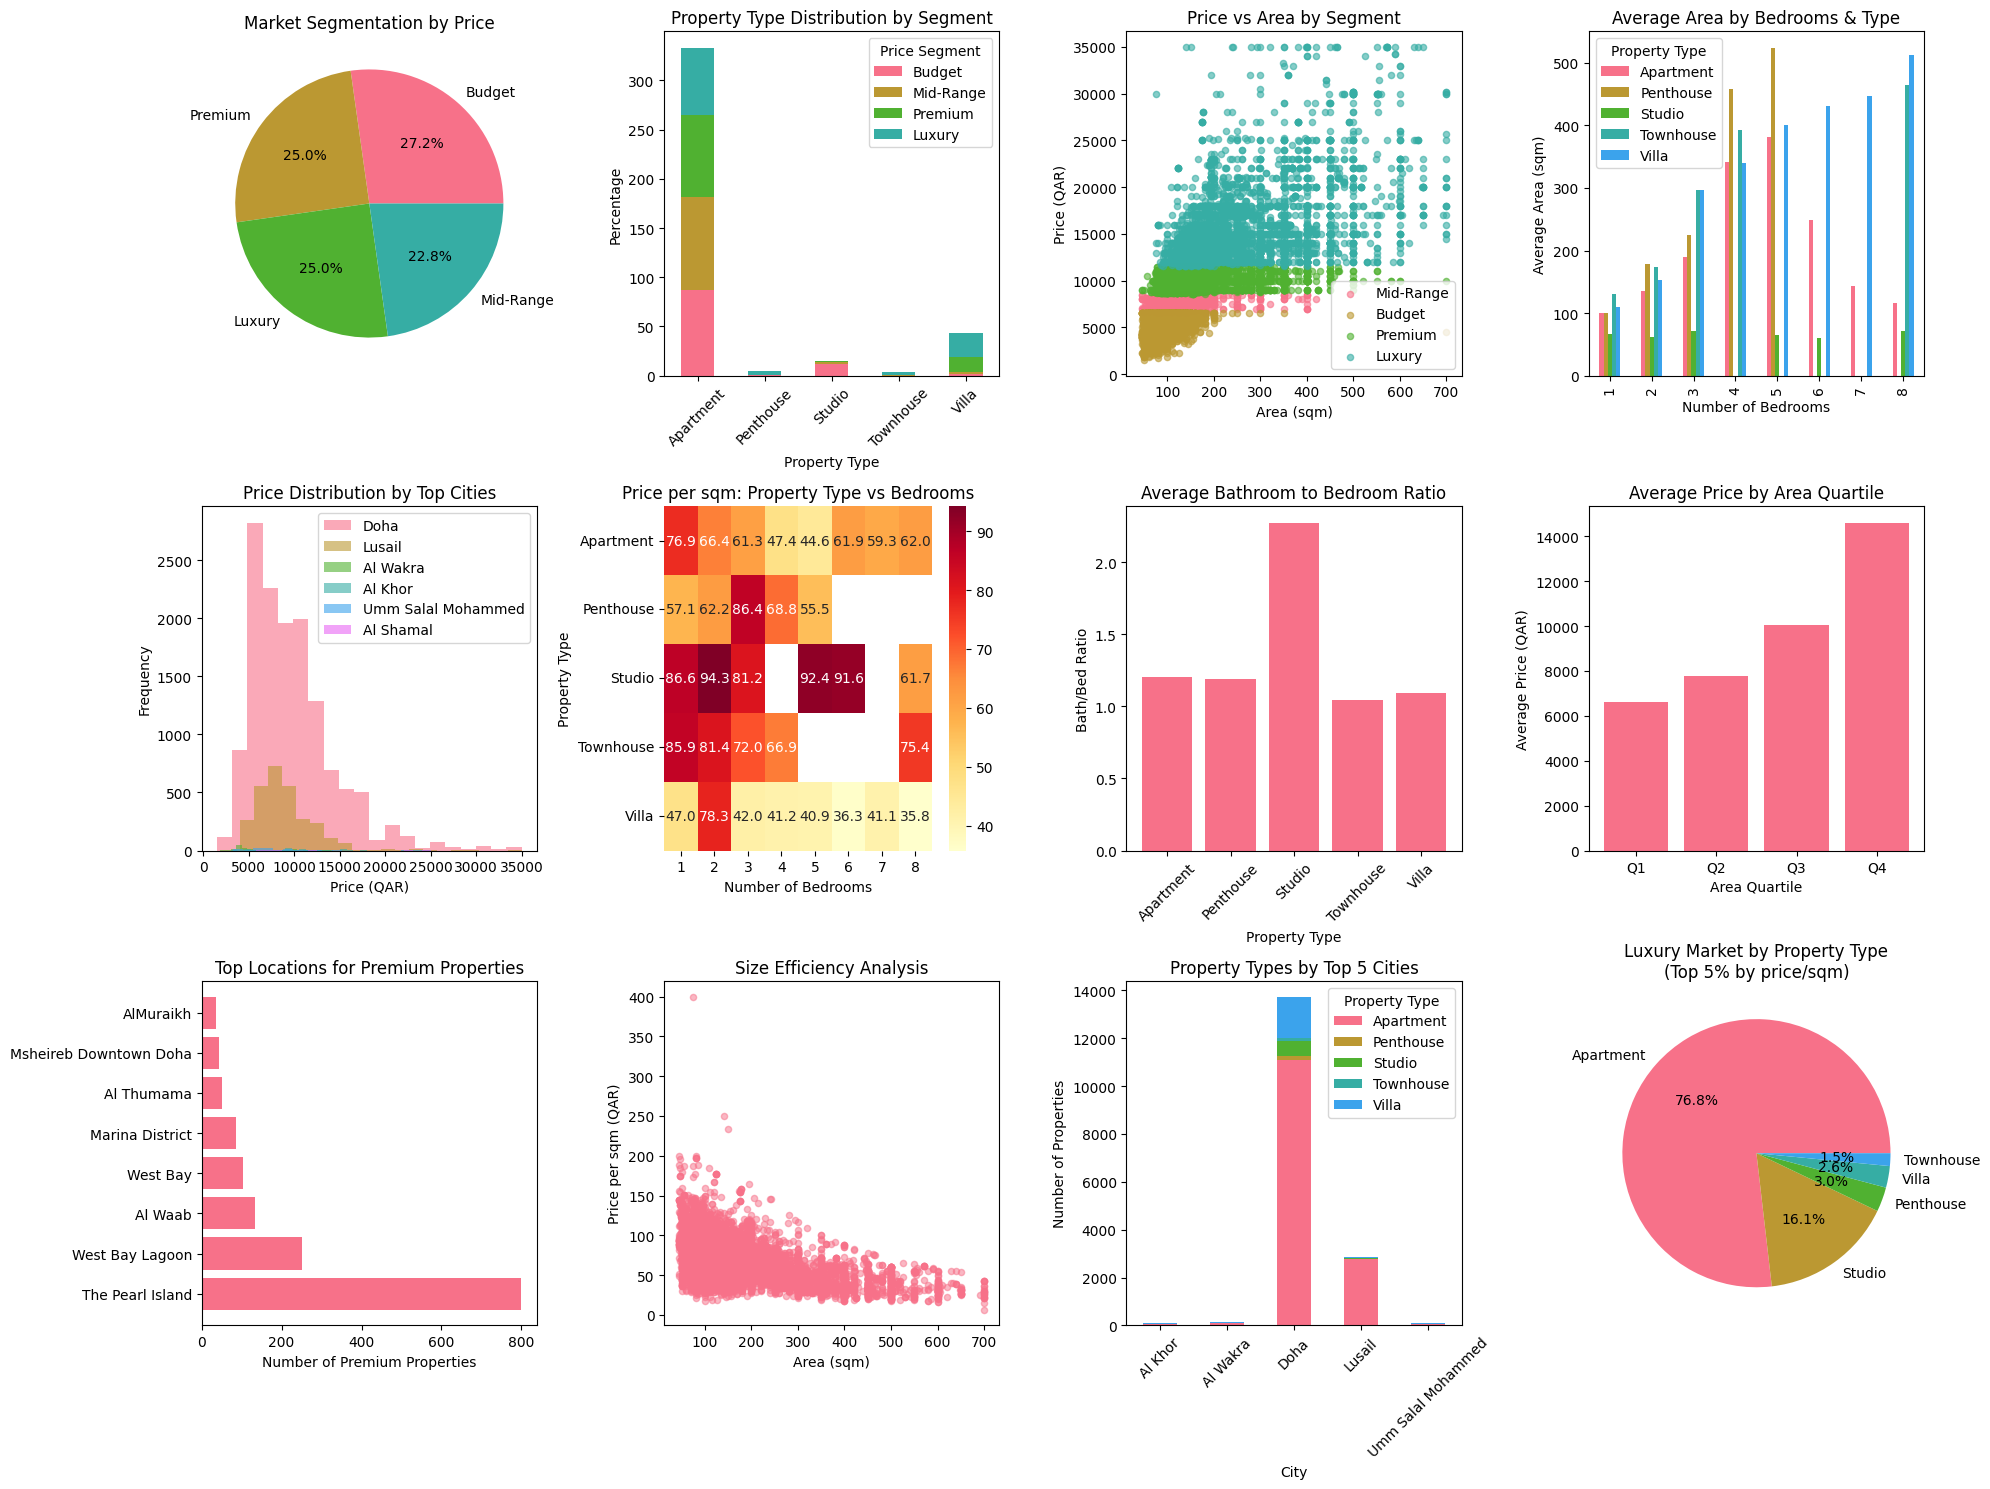

In [71]:
# Market segmentation based on price ranges
print("=== MARKET SEGMENTATION ===")

# Define price segments
price_percentiles = df_clean['price'].quantile([0.25, 0.5, 0.75])
df_clean['price_segment'] = pd.cut(df_clean['price'], 
                                     bins=[0, price_percentiles[0.25], price_percentiles[0.5], 
                                          price_percentiles[0.75], float('inf')],
                                     labels=['Budget', 'Mid-Range', 'Premium', 'Luxury'])

segment_analysis = df_clean.groupby('price_segment').agg({
    'price': ['count', 'mean', 'min', 'max'],
    'area': 'mean',
    'bedrooms': 'mean',
    'price_per_sqm': 'mean'
}).round(2)

segment_analysis.columns = ['Count', 'Avg_Price', 'Min_Price', 'Max_Price', 'Avg_Area', 'Avg_Bedrooms', 'Price_per_sqm']
print("Market segments:")
display(segment_analysis)

# Property type distribution by segment
print("\n=== PROPERTY TYPE BY PRICE SEGMENT ===")
segment_property_type = pd.crosstab(df_clean['price_segment'], 
                                   df_clean['property_type'], 
                                   normalize='index') * 100
display(segment_property_type.round(1))

# Location analysis by segment
print("\n=== TOP LOCATIONS BY PRICE SEGMENT ===")
for segment in ['Budget', 'Mid-Range', 'Premium', 'Luxury']:
    segment_data = df_clean[df_clean['price_segment'] == segment]
    top_locations = segment_data['district'].value_counts().head(3)
    print(f"\n{segment} Segment:")
    for location, count in top_locations.items():
        avg_price = segment_data[segment_data['district'] == location]['price'].mean()
        print(f"  {location}: {count} properties (Avg: {avg_price:,.0f} QAR)")

# Create advanced visualizations
fig = plt.figure(figsize=(20, 15))

# Market segmentation pie chart
plt.subplot(3, 4, 1)
segment_counts = df_clean['price_segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
plt.title('Market Segmentation by Price')

# Property type by segment
plt.subplot(3, 4, 2)
segment_property_type.T.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Property Type Distribution by Segment')
plt.xlabel('Property Type')
plt.ylabel('Percentage')
plt.legend(title='Price Segment')
plt.xticks(rotation=45)

# Price vs Area by segment
plt.subplot(3, 4, 3)
for segment in df_clean['price_segment'].unique():
    segment_data = df_clean[df_clean['price_segment'] == segment]
    plt.scatter(segment_data['area'], segment_data['price'], 
               alpha=0.6, label=segment, s=20)
plt.xlabel('Area (sqm)')
plt.ylabel('Price (QAR)')
plt.title('Price vs Area by Segment')
plt.legend()

# Average area by bedrooms and property type
plt.subplot(3, 4, 4)
area_by_bed_type = df_clean.groupby(['bedrooms', 'property_type'])['area'].mean().unstack()
area_by_bed_type.plot(kind='bar', ax=plt.gca())
plt.title('Average Area by Bedrooms & Type')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Area (sqm)')
plt.legend(title='Property Type')

# Price distribution by city (top 6)
plt.subplot(3, 4, 5)
top_cities = df_clean['city'].value_counts().head(6).index
for city in top_cities:
    city_prices = df_clean[df_clean['city'] == city]['price']
    plt.hist(city_prices, alpha=0.6, label=city, bins=20)
plt.xlabel('Price (QAR)')
plt.ylabel('Frequency')
plt.title('Price Distribution by Top Cities')
plt.legend()

# Price per sqm by property type and bedrooms
plt.subplot(3, 4, 6)
price_sqm_pivot = df_clean.groupby(['property_type', 'bedrooms'])['price_per_sqm'].mean().unstack()
# Replace pd.NA with np.nan explicitly
price_sqm_pivot = price_sqm_pivot.astype(float)
# Now plot
sns.heatmap(price_sqm_pivot, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Price per sqm: Property Type vs Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Property Type')


# Bathroom to bedroom ratio analysis
plt.subplot(3, 4, 7)
df_clean['bath_to_bed_ratio'] = df_clean['bathrooms'] / df_clean['bedrooms']
ratio_analysis = df_clean.groupby('property_type')['bath_to_bed_ratio'].mean()
plt.bar(ratio_analysis.index, ratio_analysis.values)
plt.title('Average Bathroom to Bedroom Ratio')
plt.xlabel('Property Type')
plt.ylabel('Bath/Bed Ratio')
plt.xticks(rotation=45)

# Price trends by area quartiles
plt.subplot(3, 4, 8)
df_clean['area_quartile'] = pd.qcut(df_clean['area'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
area_quartile_prices = df_clean.groupby('area_quartile')['price'].mean()
plt.bar(area_quartile_prices.index, area_quartile_prices.values)
plt.title('Average Price by Area Quartile')
plt.xlabel('Area Quartile')
plt.ylabel('Average Price (QAR)')

# Premium property analysis (top 10% by price)
plt.subplot(3, 4, 9)
premium_threshold = df_clean['price'].quantile(0.9)
premium_properties = df_clean[df_clean['price'] >= premium_threshold]
premium_locations = premium_properties['district'].value_counts().head(8)
plt.barh(range(len(premium_locations)), premium_locations.values)
plt.title('Top Locations for Premium Properties')
plt.xlabel('Number of Premium Properties')
plt.yticks(range(len(premium_locations)), premium_locations.index)

# Size efficiency (price per sqm vs area)
plt.subplot(3, 4, 10)
plt.scatter(df_clean['area'], df_clean['price_per_sqm'], alpha=0.5, s=20)
plt.xlabel('Area (sqm)')
plt.ylabel('Price per sqm (QAR)')
plt.title('Size Efficiency Analysis')

# Property type by city (top 5 cities)
plt.subplot(3, 4, 11)
top_5_cities = df_clean['city'].value_counts().head(5).index
city_type_data = df_clean[df_clean['city'].isin(top_5_cities)]
city_type_crosstab = pd.crosstab(city_type_data['city'], city_type_data['property_type'])
city_type_crosstab.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Property Types by Top 5 Cities')
plt.xlabel('City')
plt.ylabel('Number of Properties')
plt.legend(title='Property Type')
plt.xticks(rotation=45)

# Luxury market analysis (top 5% by price per sqm)
plt.subplot(3, 4, 12)
luxury_threshold = df_clean['price_per_sqm'].quantile(0.95)
luxury_properties = df_clean[df_clean['price_per_sqm'] >= luxury_threshold]
luxury_types = luxury_properties['property_type'].value_counts()
plt.pie(luxury_types.values, labels=luxury_types.index, autopct='%1.1f%%')
plt.title('Luxury Market by Property Type\n(Top 5% by price/sqm)')

plt.tight_layout()
plt.show()

## Predictive Analysis and Recommendations

Building insights for price prediction and market recommendations.

=== PRICE PREDICTION MODEL ===
Random Forest Model Performance:
  Mean Absolute Error: 1,784 QAR
  R² Score: 0.655
  Average prediction error: 18.4% of average price

Top 10 Most Important Features:


,feature,importance
2,area,0.822352
1,bathrooms,0.036173
0,bedrooms,0.034185
4,type_Penthouse,0.030409
7,type_Villa,0.021449
14,city_Lusail,0.014261
3,type_Apartment,0.013730
12,city_Doha,0.009242
6,type_Townhouse,0.006483
11,city_Al Wakra,0.004855


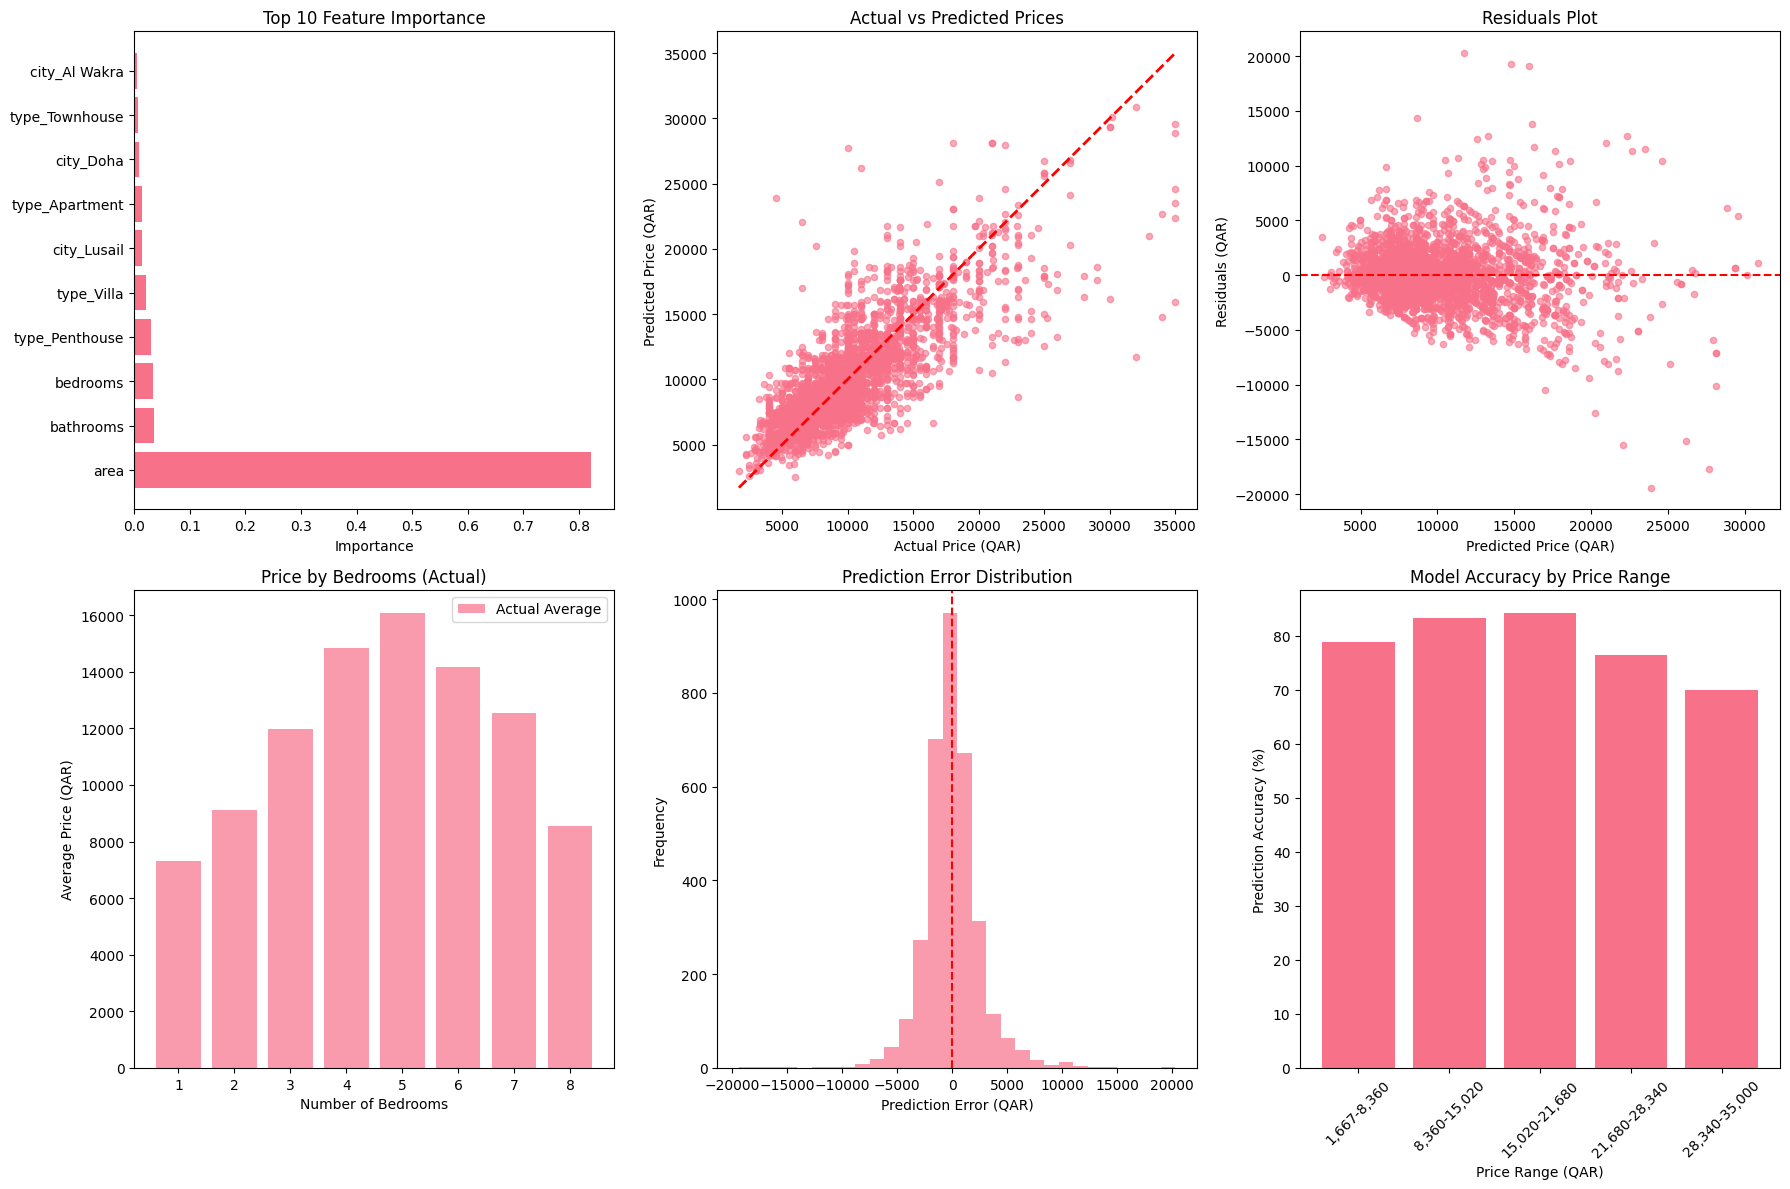

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

print("=== PRICE PREDICTION MODEL ===")

# Prepare data for modeling
model_data = df_clean.copy()

# Create dummy variables for categorical features
property_type_dummies = pd.get_dummies(model_data['property_type'], prefix='type')
city_dummies = pd.get_dummies(model_data['city'], prefix='city')

# Select features for modeling
feature_columns = ['bedrooms', 'bathrooms', 'area']
X_numeric = model_data[feature_columns]
X_categorical = pd.concat([property_type_dummies, city_dummies], axis=1)
X = pd.concat([X_numeric, X_categorical], axis=1)
y = model_data['price']

# Remove rows with missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model Performance:")
print(f"  Mean Absolute Error: {mae_rf:,.0f} QAR")
print(f"  R² Score: {r2_rf:.3f}")
print(f"  Average prediction error: {mae_rf/y_test.mean()*100:.1f}% of average price")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
display(feature_importance.head(10))

# Visualize model performance and insights
plt.figure(figsize=(18, 12))

# Feature importance plot
plt.subplot(2, 3, 1)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')

# Actual vs Predicted prices
plt.subplot(2, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (QAR)')
plt.ylabel('Predicted Price (QAR)')
plt.title('Actual vs Predicted Prices')

# Residuals plot
plt.subplot(2, 3, 3)
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price (QAR)')
plt.ylabel('Residuals (QAR)')
plt.title('Residuals Plot')

# Price prediction by bedrooms
plt.subplot(2, 3, 4)
bedroom_actual = model_data.groupby('bedrooms')['price'].mean()
plt.bar(bedroom_actual.index, bedroom_actual.values, alpha=0.7, label='Actual Average')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price (QAR)')
plt.title('Price by Bedrooms (Actual)')
plt.legend()

# Error distribution
plt.subplot(2, 3, 5)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Prediction Error (QAR)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')

# Model accuracy by price range
plt.subplot(2, 3, 6)
price_ranges = pd.cut(y_test, bins=5)
accuracy_by_range = []
range_labels = []
for price_range in price_ranges.cat.categories:
    mask = price_ranges == price_range
    if mask.sum() > 0:
        range_mae = mean_absolute_error(y_test[mask], y_pred_rf[mask])
        range_avg_price = y_test[mask].mean()
        accuracy = (1 - range_mae/range_avg_price) * 100
        accuracy_by_range.append(accuracy)
        range_labels.append(f"{price_range.left:,.0f}-{price_range.right:,.0f}")

plt.bar(range(len(accuracy_by_range)), accuracy_by_range)
plt.xlabel('Price Range (QAR)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Model Accuracy by Price Range')
plt.xticks(range(len(range_labels)), range_labels, rotation=45)

plt.tight_layout()
plt.show()

In [73]:
print("=== INVESTMENT AND MARKET RECOMMENDATIONS ===\n")

# 1. Best value propositions
print("1. BEST VALUE PROPOSITIONS:")
# Calculate value score (low price per sqm, good location, reasonable size)
df_clean['value_score'] = (
    (1 / df_clean['price_per_sqm']) * 1000 +  # Lower price per sqm is better
    (df_clean['area'] / 100) +  # Larger area is better
    (df_clean['bedrooms'] * 10)  # More bedrooms is better
)

best_value_overall = df_clean.nlargest(10, 'value_score')[['title', 'price', 'area', 'price_per_sqm', 'district', 'property_type', 'listing_url']]
print("Top 10 best value properties:")
display(best_value_overall)

# 2. Market gaps and opportunities
print("\n2. MARKET GAPS AND OPPORTUNITIES:")

# Underrepresented property types in premium locations
premium_districts = doha_districts.head(5).index
for district in premium_districts:
    district_data = df_clean[df_clean['district'] == district]
    property_types = district_data['property_type'].value_counts()
    total_in_district = len(district_data)
    print(f"\n{district} ({total_in_district} properties):")
    for prop_type in ['Apartment', 'Villa', 'Penthouse','Townhouse', 'Studio']:
        count = property_types.get(prop_type, 0)
        percentage = (count / total_in_district) * 100 if total_in_district > 0 else 0
        print(f"  {prop_type}: {count} ({percentage:.1f}%)")

# 3. Price optimization opportunities
print("\n3. PRICE OPTIMIZATION OPPORTUNITIES:")

# Properties priced significantly above/below market rate for their features
for prop_type in df_clean['property_type'].unique():
    type_data = df_clean[df_clean['property_type'] == prop_type]
    
    # Calculate expected price based on area and bedrooms
    avg_price_per_sqm = type_data['price_per_sqm'].median()
    
    overpriced = type_data[type_data['price_per_sqm'] > avg_price_per_sqm * 1.5]
    underpriced = type_data[type_data['price_per_sqm'] < avg_price_per_sqm * 0.7]
    
    print(f"\n{prop_type}:")
    print(f"  Market avg price/sqm: {avg_price_per_sqm:.2f} QAR")
    print(f"  Potentially overpriced: {len(overpriced)} properties")
    print(f"  Potentially underpriced: {len(underpriced)} properties")

# 4. Emerging markets
print("\n4. EMERGING MARKET OPPORTUNITIES:")
# Areas with growing supply but still reasonable prices
district_growth = df_clean.groupby('district').agg({
    'price': ['count', 'mean'],
    'price_per_sqm': 'mean'
}).round(2)

district_growth.columns = ['Property_Count', 'Avg_Price', 'Avg_Price_per_sqm']
district_growth = district_growth[district_growth['Property_Count'] >= 20]

# Sort by property count (supply) but filter for reasonable prices
emerging_markets = district_growth[
    (district_growth['Avg_Price_per_sqm'] < df_clean['price_per_sqm'].median()) &
    (district_growth['Property_Count'] >= 30)
].sort_values('Property_Count', ascending=False)

print("Districts with high supply and reasonable prices:")
display(emerging_markets.head(8))

# 5. Premium market insights
print("\n5. PREMIUM MARKET INSIGHTS:")
luxury_threshold = df_clean['price'].quantile(0.9)
luxury_properties = df_clean[df_clean['price'] >= luxury_threshold]

luxury_analysis = luxury_properties.groupby('property_type').agg({
    'price': ['count', 'mean'],
    'area': 'mean',
    'price_per_sqm': 'mean',
    'bedrooms': 'mean'
}).round(2)

luxury_analysis.columns = ['Count', 'Avg_Price', 'Avg_Area', 'Price_per_sqm', 'Avg_Bedrooms']
print("Luxury market analysis (top 10% by price):")
display(luxury_analysis)


=== INVESTMENT AND MARKET RECOMMENDATIONS ===

1. BEST VALUE PROPOSITIONS:
Top 10 best value properties:


,title,price,area,price_per_sqm,district,property_type,listing_url
8284,1BHK Furnished Including Kharama Close To Metro,4500,700,6.428571,Al Sadd,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
10345,Amazing 6bedrooms Villa for Rent in Al-Wukair,10000,700,14.285714,Al Wukair,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
9786,Amazing 8 BHK Unfurnished Stand-Alone Villa,12000,500,24.0,Umm Salal Mohammed,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
16471,Studio Apartment in Muntazah for family including,1800,100,18.0,Al Muntazah,Apartment,https://www.propertyfinder.qa/en/plp/rent/apar...
1665,5-Bedroom Villa in Muaither – Great Location!,10000,600,16.666667,Muaither Area,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
16724,Villa Standalone | 6 BHK |For Rent | Al Wakra,10000,600,16.666667,Al Wakrah,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
1130,Huge compound villa for staff _ Ain khalid .,11000,550,20.0,Ain Khaled,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
9224,Brand new villas 7 Bedrooms.,15000,700,21.428571,Al Markhiya,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
246,Enormous 8BDR Villa 4 Rent In Umm Salal,12000,465,25.806452,Umm Salal Mohammed,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...
354,Huge 7-Bedrooms villa in Abu Hamour Area,12000,550,21.818182,Abu Hamour,Villa,https://www.propertyfinder.qa/en/plp/rent/vill...



2. MARKET GAPS AND OPPORTUNITIES:

West Bay Lagoon (277 properties):
  Apartment: 79 (28.5%)
  Villa: 196 (70.8%)
  Penthouse: 1 (0.4%)
  Townhouse: 0 (0.0%)
  Studio: 1 (0.4%)

Al Dafna (22 properties):
  Apartment: 8 (36.4%)
  Villa: 10 (45.5%)
  Penthouse: 0 (0.0%)
  Townhouse: 2 (9.1%)
  Studio: 2 (9.1%)

Al Messila (30 properties):
  Apartment: 18 (60.0%)
  Villa: 12 (40.0%)
  Penthouse: 0 (0.0%)
  Townhouse: 0 (0.0%)
  Studio: 0 (0.0%)

Al Markhiya (30 properties):
  Apartment: 7 (23.3%)
  Villa: 23 (76.7%)
  Penthouse: 0 (0.0%)
  Townhouse: 0 (0.0%)
  Studio: 0 (0.0%)

Al Hilal (97 properties):
  Apartment: 25 (25.8%)
  Villa: 71 (73.2%)
  Penthouse: 0 (0.0%)
  Townhouse: 0 (0.0%)
  Studio: 1 (1.0%)

3. PRICE OPTIMIZATION OPPORTUNITIES:

Apartment:
  Market avg price/sqm: 66.67 QAR
  Potentially overpriced: 897 properties
  Potentially underpriced: 1909 properties

Studio:
  Market avg price/sqm: 88.71 QAR
  Potentially overpriced: 25 properties
  Potentially underpriced: 108 p

,Property_Count,Avg_Price,Avg_Price_per_sqm
district,,,
Al Waab,822,10541.29,51.37
Fox Hills,780,7005.39,61.43
Al Sadd,713,6273.04,55.91
Fereej Bin Mahmoud,453,7439.9,58.54
Al Mansoura,414,5633.32,50.98
Old Airport Road,343,6858.45,49.63
Al Muntazah,309,6120.31,57.02
West Bay Lagoon,277,20582.99,57.24



5. PREMIUM MARKET INSIGHTS:
Luxury market analysis (top 10% by price):


,Count,Avg_Price,Avg_Area,Price_per_sqm,Avg_Bedrooms
property_type,,,,,
Apartment,1004,18077.14,258.14,77.95,3.02
Penthouse,141,23105.17,307.22,83.07,3.33
Townhouse,67,21206.76,304.31,77.07,2.94
Villa,634,19640.35,424.34,50.2,4.65


## Executive Summary and Key Findings

Summary of all key insights and actionable recommendations from the Qatar rental market analysis.

In [74]:
print("="*80)
print("QATAR RENTAL PROPERTY MARKET - EXECUTIVE SUMMARY")
print("="*80)

print(f"""
DATASET OVERVIEW:
• Total Properties Analyzed: {len(df_clean):,}
• Data Quality: {len(df_clean)/len(df)*100:.1f}% of original data after cleaning
• Geographic Coverage: {df_clean['city'].nunique()} cities, {df_clean['district'].nunique()} districts
• Property Types: {', '.join(df_clean['property_type'].unique())}

MARKET CHARACTERISTICS:
• Average Monthly Rent: {df_clean['price'].mean():,.0f} QAR
• Median Monthly Rent: {df_clean['price'].median():,.0f} QAR
• Average Property Size: {df_clean['area'].mean():.0f} sqm
• Average Price per sqm: {df_clean['price_per_sqm'].mean():.2f} QAR/sqm

MARKET COMPOSITION:""")

for prop_type in df_clean['property_type'].value_counts().index:
    count = df_clean['property_type'].value_counts()[prop_type]
    percentage = (count / len(df_clean)) * 100
    avg_price = df_clean[df_clean['property_type'] == prop_type]['price'].mean()
    print(f"• {prop_type}: {percentage:.1f}% of market (Avg: {avg_price:,.0f} QAR)")

print(f"""
GEOGRAPHIC INSIGHTS:
• Doha Dominance: {df_clean['city'].value_counts()['Doha']:,} properties ({df_clean['city'].value_counts()['Doha']/len(df_clean)*100:.1f}% of market)
• Most Expensive City: {city_stats.index[0]} ({city_stats.iloc[0]['Avg_Price']:,.0f} QAR avg)
• Best Value City: {city_stats.sort_values('Avg_Price_per_sqm').index[0]} ({city_stats.sort_values('Avg_Price_per_sqm').iloc[0]['Avg_Price_per_sqm']:.2f} QAR/sqm)
• Premium Districts: {', '.join(doha_districts.head(3).index)}

PROPERTY FEATURES:
• Most Common: {df_clean['bedrooms'].mode()[0]:.0f} bedrooms, {df_clean['bathrooms'].mode()[0]:.0f} bathrooms
• Size Range: {df_clean['area'].min():.0f} - {df_clean['area'].max():,.0f} sqm
• Strong Correlation: Area vs Price (r = {df_clean[['area', 'price']].corr().iloc[0,1]:.3f})

MARKET SEGMENTS:""")

for segment in ['Budget', 'Mid-Range', 'Premium', 'Luxury']:
    segment_data = df_clean[df_clean['price_segment'] == segment]
    count = len(segment_data)
    percentage = (count / len(df_clean)) * 100
    avg_price = segment_data['price'].mean()
    price_range = f"{segment_data['price'].min():,.0f} - {segment_data['price'].max():,.0f}"
    print(f"• {segment}: {percentage:.1f}% ({price_range} QAR, Avg: {avg_price:,.0f})")

print(f"""
PREDICTIVE MODEL PERFORMANCE:
• Model Accuracy (R²): {r2_rf:.3f}
• Average Prediction Error: {mae_rf:,.0f} QAR ({mae_rf/y_test.mean()*100:.1f}% of avg price)
• Most Important Factors: {', '.join(feature_importance.head(3)['feature'].tolist())}

KEY RECOMMENDATIONS:

INVESTORS:
• Focus on emerging districts with high supply and reasonable prices
• Consider undervalued properties in premium locations
• Villa market shows strong price premiums - opportunity for development

TENANTS:
• Best value areas: {', '.join(city_stats.sort_values('Avg_Price_per_sqm').head(3).index)}
• Consider {affordable_type}s for budget-friendly options
• Look beyond Doha for significant savings

DEVELOPERS:
• Market gaps in premium districts for certain property types
• Strong demand for mid-range properties ({segment_analysis.loc['Mid-Range', 'Count']:.0f} properties)
• Price per sqm varies significantly by location - research location premiums

MARKET TRENDS:
• Apartment market dominates with {df_clean['property_type'].value_counts()['Apartment']:,} properties
• Premium market concentrated in {len(luxury_properties)} properties (top 10%)
• Strong correlation between property size and price across all segments

CAUTION AREAS:
• Some properties may be overpriced relative to market standards
• Luxury market shows high price volatility
• Location premiums can exceed 200% between districts
""")

print("="*80)
print("THANK YOU FOR YOUR TIME")
print("="*80)

QATAR RENTAL PROPERTY MARKET - EXECUTIVE SUMMARY

DATASET OVERVIEW:
• Total Properties Analyzed: 16,910
• Data Quality: 88.5% of original data after cleaning
• Geographic Coverage: 8 cities, 105 districts
• Property Types: Apartment, Studio, Villa, Penthouse, Townhouse

MARKET CHARACTERISTICS:
• Average Monthly Rent: 9,636 QAR
• Median Monthly Rent: 8,600 QAR
• Average Property Size: 160 sqm
• Average Price per sqm: 66.68 QAR/sqm

MARKET COMPOSITION:
• Apartment: 83.1% of market (Avg: 9,083 QAR)
• Villa: 10.9% of market (Avg: 13,749 QAR)
• Studio: 3.9% of market (Avg: 5,572 QAR)
• Penthouse: 1.1% of market (Avg: 19,327 QAR)
• Townhouse: 1.0% of market (Avg: 15,442 QAR)

GEOGRAPHIC INSIGHTS:
• Doha Dominance: 13,704 properties (81.0% of market)
• Most Expensive City: Al Shamal (13,535 QAR avg)
• Best Value City: Al Khor (35.86 QAR/sqm)
• Premium Districts: West Bay Lagoon, Al Dafna, Al Messila

PROPERTY FEATURES:
• Most Common: 2 bedrooms, 2 bathrooms
• Size Range: 45 - 700 sqm
• Strong